In [15]:
import sys
sys.path.append('ipfnlite/')
sys.path.append('/afs/ipp/aug/ads-diags/common/python/lib/')
from getsig import getsig
from closest import closest
from sliding_window import sliding_window
from get_ric_avr_profile import get_ric_avr_profile
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import dd
import kk_abock
import numpy as np
from scipy import interpolate
#plt.style.use('./Styles/darklab.mplstyle')

# Plotting parameters

In [2]:
# Set up the colors
prop_cycle = plt.rcParams['axes.prop_cycle']
color_values = prop_cycle.by_key()['color']
color_names = ["bl", "or", "gn", "rd", "vlt", "brwn", "mg", "gr", "lgn", "cn"]

colors = {}
for ii, color in enumerate(color_names):
    colors.update({color: color_values[ii]})

In [3]:
# Set up the diagnostic plotting styles
diag_plt_style = {
    "RIC_ant1":{"color":colors["bl"], "marker":"^", "markerfacecolor":"white", "label":"RIC top.", "linestyle":"-"},
    "RIC_ant4":{"color":colors["or"], "marker":"o", "markerfacecolor":"white", "label":"RIC mid.", "linestyle":"-"},
    "RIC_ant8":{"color":colors["gn"], "marker":"D", "markerfacecolor":"white", "label":"RIC bot.", "linestyle":"-"},
    "LiB":{"color":colors["vlt"], "marker":"p", "markerfacecolor":"white", "label":"LiB", "linestyle":"-"}
}

In [4]:
lim_pos_Rz = {
    "RIC_ant1" : {"R":2.137, "z": 0.442},
    "RIC_ant4" : {"R":2.202, "z": 0.03},
    "RIC_ant8" : {"R":2.054, "z": -0.42}
}

# Reading data

In [17]:
shotnr = 37750
antenna = 1  # 1 - topplane, 4 - midplane, 8 - bottomplane 

# read the profiles
diag_name = "RIC_ant{}".format(str(antenna))
data = {diag_name:{}}
shotfile = getsig(shotnr, "RIC", "Ne_Ant1")
data[diag_name]["rhop"] = shotfile.area[:]
data[diag_name]["ne"] = shotfile.data
data[diag_name]["time"] = shotfile.time

# read the equilibrium
eq = kk_abock.kk()
eq.Open(shotnr, diag='EQH')

True

# Plotting individual profiles

Profile with ICRF limiter position

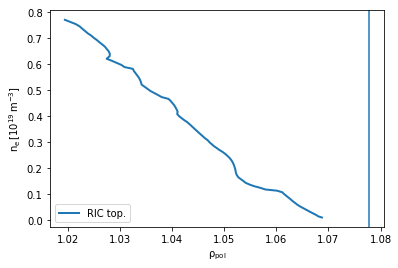

In [18]:
time = 2.1

tind = closest(data[diag_name]["time"], time)

rhop_limiter = eq.Rz_to_rhopol(time, lim_pos_Rz[diag_name]["R"], lim_pos_Rz[diag_name]["z"])

plt.plot(
    data[diag_name]["rhop"][tind, :], 
    data[diag_name]["ne"][tind, :]*1e-19, 
    label=diag_plt_style[diag_name]["label"], lw=2, 
    c=diag_plt_style[diag_name]["color"],
    linestyle=diag_plt_style[diag_name]["linestyle"])
plt.axvline(
    rhop_limiter,
    c=diag_plt_style[diag_name]["color"]
)
plt.xlabel(r'$\mathrm{\rho_{pol}}$')
plt.ylabel(r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$')
plt.legend()
plt.show()

# Plotting averaged profiles from a time interval

In [19]:
time_start = 2.1
time_end = 2.2

tind_start = closest(data[diag_name]["time"], time_start)
tind_end = closest(data[diag_name]["time"], time_end)


avr_rhop, avr_ne, min_rhop, max_rhop = get_ric_avr_profile(
    data[diag_name]["rhop"][tind_start:tind_end, :],
    data[diag_name]["ne"][tind_start:tind_end, :], 
    num=20, ne_min=0
)

min_rhop, max_rhop can be considered as error bars

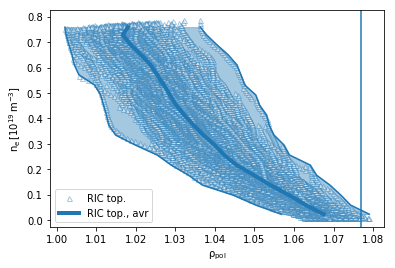

In [20]:
rhop_limiter = eq.Rz_to_rhopol(
    np.average(data[diag_name]["time"][tind_start:tind_end]), 
    lim_pos_Rz[diag_name]["R"], 
    lim_pos_Rz[diag_name]["z"]
)

plt.plot(
    data[diag_name]["rhop"][tind_start:tind_end, :],
    data[diag_name]["ne"][tind_start:tind_end, :]*1e-19,
    lw=2, linestyle="", 
    c=diag_plt_style[diag_name]["color"],
    marker=diag_plt_style[diag_name]["marker"], 
    markerfacecolor=diag_plt_style[diag_name]["markerfacecolor"], 
    markersize=5.0, zorder=1, alpha=0.4
)

plt.plot(
    data[diag_name]["rhop"][tind_start:tind_end, :][0],
    data[diag_name]["ne"][tind_start:tind_end, :][0]*1e-19,
    label=diag_plt_style[diag_name]["label"],
    lw=2, linestyle="", 
    c=diag_plt_style[diag_name]["color"],
    marker=diag_plt_style[diag_name]["marker"], 
    markerfacecolor=diag_plt_style[diag_name]["markerfacecolor"], 
    markersize=5.0, zorder=1, alpha=0.4
)

plt.plot(
    avr_rhop, avr_ne*1e-19,
    label="{}, avr".format(diag_plt_style[diag_name]["label"]), 
    lw=4, 
    c=diag_plt_style[diag_name]["color"],
    markersize=5.0, linestyle="-")

plt.fill_betweenx(avr_ne*1e-19, min_rhop, max_rhop, 
                color=diag_plt_style[diag_name]["color"],
                alpha=0.4)
plt.plot(min_rhop, avr_ne*1e-19, color=diag_plt_style[diag_name]["color"])
plt.plot(max_rhop, avr_ne*1e-19, color=diag_plt_style[diag_name]["color"])
plt.axvline(
    rhop_limiter,
    c=diag_plt_style[diag_name]["color"]
)
plt.xlabel(r'$\mathrm{\rho_{pol}}$')
plt.ylabel(r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$')
plt.legend()
plt.show()

# Isodensitiyes

In [23]:
time_of_average = 100  # (ms)
rhop_avr = []
ne_avr = []
rhop_max = []
rhop_min = []
foo_lst = []

dt = np.diff(data[diag_name]["time"])[0]
pts_in_time_window = np.int(np.floor(time_of_average*1e-3 / dt))

time_avr = np.average(
    sliding_window(data[diag_name]["time"], pts_in_time_window, stepsize=pts_in_time_window), 
    axis=1
)

rhop_sliced = sliding_window(data[diag_name]["rhop"], pts_in_time_window, stepsize=pts_in_time_window, axis=0)
ne_sliced = sliding_window(data[diag_name]["ne"], pts_in_time_window, stepsize=pts_in_time_window, axis=0)

for ii in range(rhop_sliced.shape[0]):
    avr_rhop, avr_ne, min_rhop, max_rhop = get_ric_avr_profile(
        rhop_sliced[ii,:,:],
        ne_sliced[ii,:,:], 
        num=20, ne_min=0
    )
    rhop_avr.append(avr_rhop)
    ne_avr.append(avr_ne)
    rhop_max.append(max_rhop)
    rhop_min.append(max_rhop)
    foo_lst.append(interpolate.interp1d(avr_ne, avr_rhop, bounds_error=False))
    
rhop_avr = np.asarray(rhop_avr)
ne_avr = np.asarray(ne_avr)
rhop_max = np.asarray(rhop_max)
rhop_min = np.asarray(rhop_min)

# Limiter position
rhop_limiter_lst = []
for tt in time_avr:
    rhop_limiter = eq.Rz_to_rhopol(
        tt, 
        lim_pos_Rz[diag_name]["R"], 
        lim_pos_Rz[diag_name]["z"]
    )
    rhop_limiter_lst.append(rhop_limiter[0])
rhop_limiter_lst = np.asarray(rhop_limiter_lst)

In [24]:
iso_density_lst = [1, 2, 3, 4, 5, 7]  # x 1e18
iso_density = {}

for ne in iso_density_lst:
    key = str(ne)
    ne *= 1e18
    iso_rhop = []
    for ii, tt in enumerate(time_avr):
        iso_rhop.append(foo_lst[ii](ne))
    iso_density[key] = np.asarray(iso_rhop)

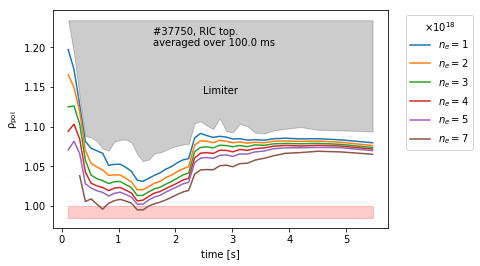

In [25]:
fig, ax = plt.subplots()
for ne in iso_density_lst:
    key = str(ne)
    plt.plot(time_avr, iso_density[key], label="{}{}".format("$n_e = $", key))

plt.legend(title=r"$\times 10^{18}$", bbox_to_anchor=(1.04,1), loc="upper left")
plt.text(0.3, 0.9, '#{}, {}'.format(shotnr, diag_plt_style[diag_name]["label"]), ha='left', va='center', 
                  transform=fig.axes[0].transAxes)
plt.text(0.3, 0.85, 'averaged over {} ms'.format((time_end - time_start)*1e3), ha='left', va='center', 
                  transform=fig.axes[0].transAxes)
# Limiter
ymin, ymax = fig.axes[0].get_ylim()
if rhop_limiter_lst.max() > ymax:
    ymax = rhop_limiter_lst.max()
plt.fill_between(time_avr, rhop_limiter_lst, y2=ymax, color="k", alpha=0.2)
xmin, xmax = fig.axes[0].get_xlim()
plt.text(
    xmin + (xmax - xmin)/2, 
    np.min(rhop_limiter_lst) + (ymax - np.min(rhop_limiter_lst))/2, 
    'Limiter', ha='center', va='center'
)

plt.fill_between(time_avr, 1, y2=ymin, color="r", alpha=0.2)
plt.xlabel(r'time [s]')
plt.ylabel(r'$\mathrm{\rho_{pol}}$')
plt.show()

# Profilogram

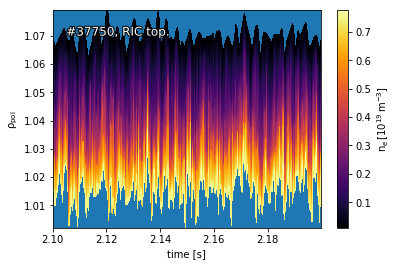

In [26]:
time_start = 2.1
time_end = 2.2

tind_start = closest(data[diag_name]["time"], time_start)
tind_end = closest(data[diag_name]["time"], time_end)

t = [data[diag_name]["time"][tind_start:tind_end]]
rhop = data[diag_name]["rhop"][tind_start:tind_end, :]
ne =  data[diag_name]["ne"][tind_start:tind_end, :]

fig, ax = plt.subplots()

plt.pcolormesh(
    np.multiply(np.array(t).T, np.ones_like(rhop)),
    data[diag_name]["rhop"][tind_start:tind_end, :],
    data[diag_name]["ne"][tind_start:tind_end, :]*1e-19,
    cmap=plt.get_cmap('inferno')
)
fig.axes[0].set_facecolor('#1f77b4')
cbar = plt.colorbar()
cbar.set_label(r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$')
plt.xlabel(r'time [s]')
plt.ylabel(r'$\mathrm{\rho_{pol}}$')
plt.text(
    0.05, 0.9, '#{}, {}'.format(shotnr, diag_plt_style[diag_name]["label"]), 
    ha='left', va='center', 
    transform=fig.axes[0].transAxes, color='white', fontsize=12,
    path_effects=[pe.withStroke(linewidth=2, foreground="k")]
)
plt.show()